In [15]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import time

In [20]:
import numpy as np

def pagerank(M, num_iterations: int = 100, d: float = 0.85):
    """PageRank algorithm with explicit number of iterations. Returns ranking of nodes (pages) in the adjacency matrix.

    Parameters
    ----------
    M : numpy array
        adjacency matrix where M_i,j represents the link from 'j' to 'i', such that for all 'j'
        sum(i, M_i,j) = 1
    num_iterations : int, optional
        number of iterations, by default 100
    d : float, optional
        damping factor, by default 0.85

    Returns
    -------
    numpy array
        a vector of ranks such that v_i is the i-th rank from [0, 1],
        v sums to 1

    """
    N = M.shape[1]
    v = np.ones(N) / N
    M_hat = (d * M + (1 - d) / N)
    for i in range(num_iterations):
        v = M_hat @ v
    return v

M = np.array([[0, 0, 0, 0, 1],
              [0.5, 0, 0, 0, 0],
              [0.5, 0, 0, 0, 0],
              [0, 1, 0.5, 0, 0],
              [0, 0, 0.5, 1, 0]])
v = pagerank(M, 100, 0.85)

In [21]:
N = M.shape[1]
v = np.ones(N) / N
d = 0.85
M_hat = (d * M + (1 - d) / N)


In [22]:
M_hat.dot(v)

array([0.2  , 0.115, 0.115, 0.285, 0.285])

In [24]:
M_hat

array([[0.03 , 0.03 , 0.03 , 0.03 , 0.88 ],
       [0.455, 0.03 , 0.03 , 0.03 , 0.03 ],
       [0.455, 0.03 , 0.03 , 0.03 , 0.03 ],
       [0.03 , 0.88 , 0.455, 0.03 , 0.03 ],
       [0.03 , 0.03 , 0.455, 0.88 , 0.03 ]])

In [26]:
(0.03+0.03+0.03+0.03+0.88)*1/5

0.2

In [25]:
v

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [16]:
# Labeling (getting type and nametag to dictionary)

add_label = pd.read_csv("Labeling/addresslabel.txt", names = ["addID", "type", "nametag"] , sep = " ")
add_label = add_label.set_index("addID")

genesis = pd.read_csv("Labeling/genesis_labels.txt", usecols = [0,1], names = ["addID", "type"] , sep = " ")
genesis = genesis.set_index("addID")

# miner
miner = pd.read_csv("Basic_Dataset/blockminer.txt", names = ["blockID", "addID","uncle"], header=None, sep=' ')
miner_type = miner.drop_duplicates(["addID"])
miner_type["type"] = "Miner" 
miner_type = miner_type[["addID", "type"]]
miner_type = miner_type.set_index("addID")

label_dic = add_label.to_dict("index")
genesis_dic = genesis.to_dict("index")
miner_dic = miner_type.to_dict("index")

/home/lecture/.pyenv/versions/3.5.0/envs/atp_2019/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [17]:
# Define functions

def delete_by_edge_threshold_and_degree(graph, value, threshold, num = 0):
    thre = np.percentile(np.array(list(graph.edges.data('value')))[:,2], threshold)
    selected_edges = [(u,v) for u,v,e in graph.edges(data=True) if e[value] < thre]
    graph.remove_edges_from(list(map(lambda e: (e[0], e[1]), selected_edges)))
    graph = max(nx.weakly_connected_component_subgraphs(graph), key = len) 
    
    selected_nodes = [node for node,degree in graph.degree() if degree < num]
    graph.remove_nodes_from(selected_nodes)
    graph = max(nx.weakly_connected_component_subgraphs(graph), key = len) 
    return graph

def give_node_threshold(graph, value, threshold):
    selected_nodes = [node for (node, data) in graph.nodes(data=True) if data[value] < threshold]
    graph.remove_nodes_from(selected_nodes)
    graph = max(nx.weakly_connected_component_subgraphs(graph), key = len) 
    return graph

def give_node_color(graph):
    for node in graph.nodes():
        ty = graph.nodes[node].get("type")
        if ty == "Miner":
            graph.nodes[node]["color"] = "#ff0000"#10 #"r"
        elif ty == "Exchange":
            graph.nodes[node]["color"] = "#00ff00" #20 #"g"
        elif ty == "Gambling":
            graph.nodes[node]["color"] = "#ffff00" #"y"
        elif ty == "genesis":
            graph.nodes[node]["color"] = "#0000ff" #40 #"b"
        elif ty == "ICO":
            graph.nodes[node]["color"] = "#00ffff" # aqua
        elif ty != None:
            graph.nodes[node]["color"] = "#ff3399" # pink
        else:
            graph.nodes[node]["color"] = "#808080" #100 #"k"

def give_node_deep_color(graph):
    for node in graph.nodes():
        ty = graph.nodes[node].get("type")
        if ty == "Miner":
            graph.nodes[node]["deep_color"] = "#d9534f"#10 #"r"
        elif ty == "Exchange":
            graph.nodes[node]["deep_color"] = "#5cb85c" #20 #"g"
        elif ty == "Gambling":
            graph.nodes[node]["deep_color"] = "#ffff00" #"y"
        elif ty == "genesis":
            graph.nodes[node]["deep_color"] = "#0275dB" #40 #"b"
        elif ty == "ICO":
            graph.nodes[node]["deep_color"] = "#5fedeb" # aqua
        elif ty != None:
            graph.nodes[node]["deep_color"] = "#aa46be" # pink
        else:
            graph.nodes[node]["deep_color"] = "#808080" #100 #"k"

def option(graph):
    degree_centrality = nx.degree_centrality(graph)
    nx.set_node_attributes(graph, degree_centrality, "degree_centrality")
    
    options = {
        'node_size' : [np.log(n[1]["degree_centrality"] + 1)*15000 for n in graph.nodes(data=True)],
        'node_color': [n[1]["color"] for n in graph.nodes(data=True)],
        'width': [np.sqrt(e["value"]*pow(10,-23)) for u,v,e in graph.edges(data=True)],
        'edge_color': 'gray',
        'labels': nx.get_node_attributes(graph,"nametag"),
        'font_size': 17}
    return options

def option_pr(graph, personal_type):
    options = {
        'node_size' : [np.log(n[1][personal_type]+1) * 100000 for n in graph.nodes(data=True)],
        'node_color': [n[1]["color"] for n in graph.nodes(data=True)],
        'width': [np.sqrt(e["value"]*pow(10,-23)) for u,v,e in graph.edges(data=True)],
        'edge_color': 'gray',
        'labels': nx.get_node_attributes(graph,"nametag"),
        'font_size': 17}
    return options

def select_top15(sorted_list, nametag, type_, colors):
    x = []
    y = []
    c = []
    for i in range(15):
        name = nametag.get(sorted_list[i][0])
        node_type = type_.get(sorted_list[i][0])
        color = colors.get(sorted_list[i][0])
        if name:
            node_name = name
        else:
            node_name = str(sorted_list[i][0])
        if node_type:
            node_name = node_name + "(" + str(node_type) + ")"
        
        x.append(node_name)
        y.append(sorted_list[i][1])
        c.append(color)
    return x,y,c

def get_tx_edges(tx_filename, txvalue_filename, miner):
    # setting transaction

    transaction = pd.read_csv(tx_filename, names = ["txID", "blockID", "in", "out"], header=None, sep=" ")
    txvalue = pd.read_csv(txvalue_filename, names = ["txID", "value", "gas_price", "gas_used"], header=None, sep=" ")
    transaction = pd.merge(transaction, txvalue, on="txID")
    

    # if you want to think tx_fee as one of the transaction, merge miner information to transaction

    transaction = pd.merge(transaction, miner, on="blockID", how = "left")
    transaction["tx_fee"] = transaction["gas_price"]*transaction["gas_used"]
    miner_txfee = transaction[["out", "addID", "tx_fee"]]
    miner_txfee = miner_txfee.rename(columns = {"addID": "in", "tx_fee": "value"})
    transaction = pd.concat([transaction, miner_txfee])

    # 중복된 거래의 경우 value를 합해준다
    real_tx = transaction.groupby(["in", "out"], as_index=False).agg({"value": np.sum})
    return real_tx

def get_tx_edges_bytime(tx_filename, txvalue_filename, miner, time_from, time_to):
    # setting transaction

    transaction = pd.read_csv(tx_filename, names = ["txID", "blockID", "in", "out"], header=None, sep=" ")
    txvalue = pd.read_csv(txvalue_filename, names = ["txID", "value", "gas_price", "gas_used"], header=None, sep=" ")
    txtime = pd.read_csv("Basic_Dataset/txtime.txt", names = ["txID", "txtime"], header=None, sep=" ")
    transaction = pd.merge(transaction, txtime, on="txID", how = "left")
    transaction = transaction[(transaction.txtime >= time_from) & (transaction.txtime < time_to)]
  
    transaction = pd.merge(transaction, txvalue, on="txID", how = "left")
    
    # if you want to think tx_fee as one of the transaction, merge miner information to transaction

    transaction = pd.merge(transaction, miner, on="blockID", how = "left")
    transaction["tx_fee"] = transaction["gas_price"]*transaction["gas_used"]
    miner_txfee = transaction[["out", "addID", "tx_fee"]]
    miner_txfee = miner_txfee.rename(columns = {"addID": "in", "tx_fee": "value"})
    transaction = pd.concat([transaction, miner_txfee])

    # 중복된 거래의 경우 value를 합해준다
    real_tx = transaction.groupby(["in", "out"], as_index=False).agg({"value": np.sum})
    return real_tx

def personalized_pagerank(graph, personal_type):
    personal = {}
    for node in graph.nodes():
        ty = graph.nodes[node].get("type")
        if ty == personal_type:
            personal[node] = 1
        else:
            personal[node] = 0
            
    pagerank = nx.pagerank(graph, alpha=0.9, personalization = personal)
    nx.set_node_attributes(graph, pagerank, personal_type+"pagerank")
    return pagerank

In [4]:
# load network data

start = time.time()
real_tx15 = get_tx_edges("Basic_Dataset/tx15.txt","Basic_Dataset/txvalue15.txt",miner)
real_tx16_1 = get_tx_edges_bytime("Basic_Dataset/tx16.txt", "Basic_Dataset/txvalue16.txt", miner, 1451606400, 1461980578)
real_tx16_2 = get_tx_edges_bytime("Basic_Dataset/tx16.txt", "Basic_Dataset/txvalue16.txt", miner, 1461980578, 1466121600)
real_tx16_3 = get_tx_edges_bytime("Basic_Dataset/tx16.txt", "Basic_Dataset/txvalue16.txt", miner, 1466121600, 1483228800)
time.time() - start

# 2015data 2016data 연결
tx = pd.concat([real_tx15, real_tx16_1], ignore_index=True)
real_tx1516_1 = tx.groupby(["in", "out"], as_index=False).agg({"value": np.sum})

/home/lecture/.pyenv/versions/3.5.0/envs/atp_2019/lib/python3.5/site-packages/ipykernel_launcher.py:103: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/lecture/.pyenv/versions/3.5.0/envs/atp_2019/lib/python3.5/site-packages/ipykernel_launcher.py:126: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [5]:
# construct networks

tx_G1 = nx.from_pandas_edgelist(real_tx1516_1, source = "out", target = "in", edge_attr=["value"], create_using=nx.DiGraph())
nx.set_node_attributes(tx_G1, label_dic)
nx.set_node_attributes(tx_G1, miner_dic)
nx.set_node_attributes(tx_G1, genesis_dic)

tx_G2 = nx.from_pandas_edgelist(real_tx16_2, source = "out", target = "in", edge_attr=["value"], create_using=nx.DiGraph())
nx.set_node_attributes(tx_G2, label_dic)
nx.set_node_attributes(tx_G2, miner_dic)
nx.set_node_attributes(tx_G2, genesis_dic)

tx_G3 = nx.from_pandas_edgelist(real_tx16_3, source = "out", target = "in", edge_attr=["value"], create_using=nx.DiGraph())
nx.set_node_attributes(tx_G3, label_dic)
nx.set_node_attributes(tx_G3, miner_dic)
nx.set_node_attributes(tx_G3, genesis_dic)

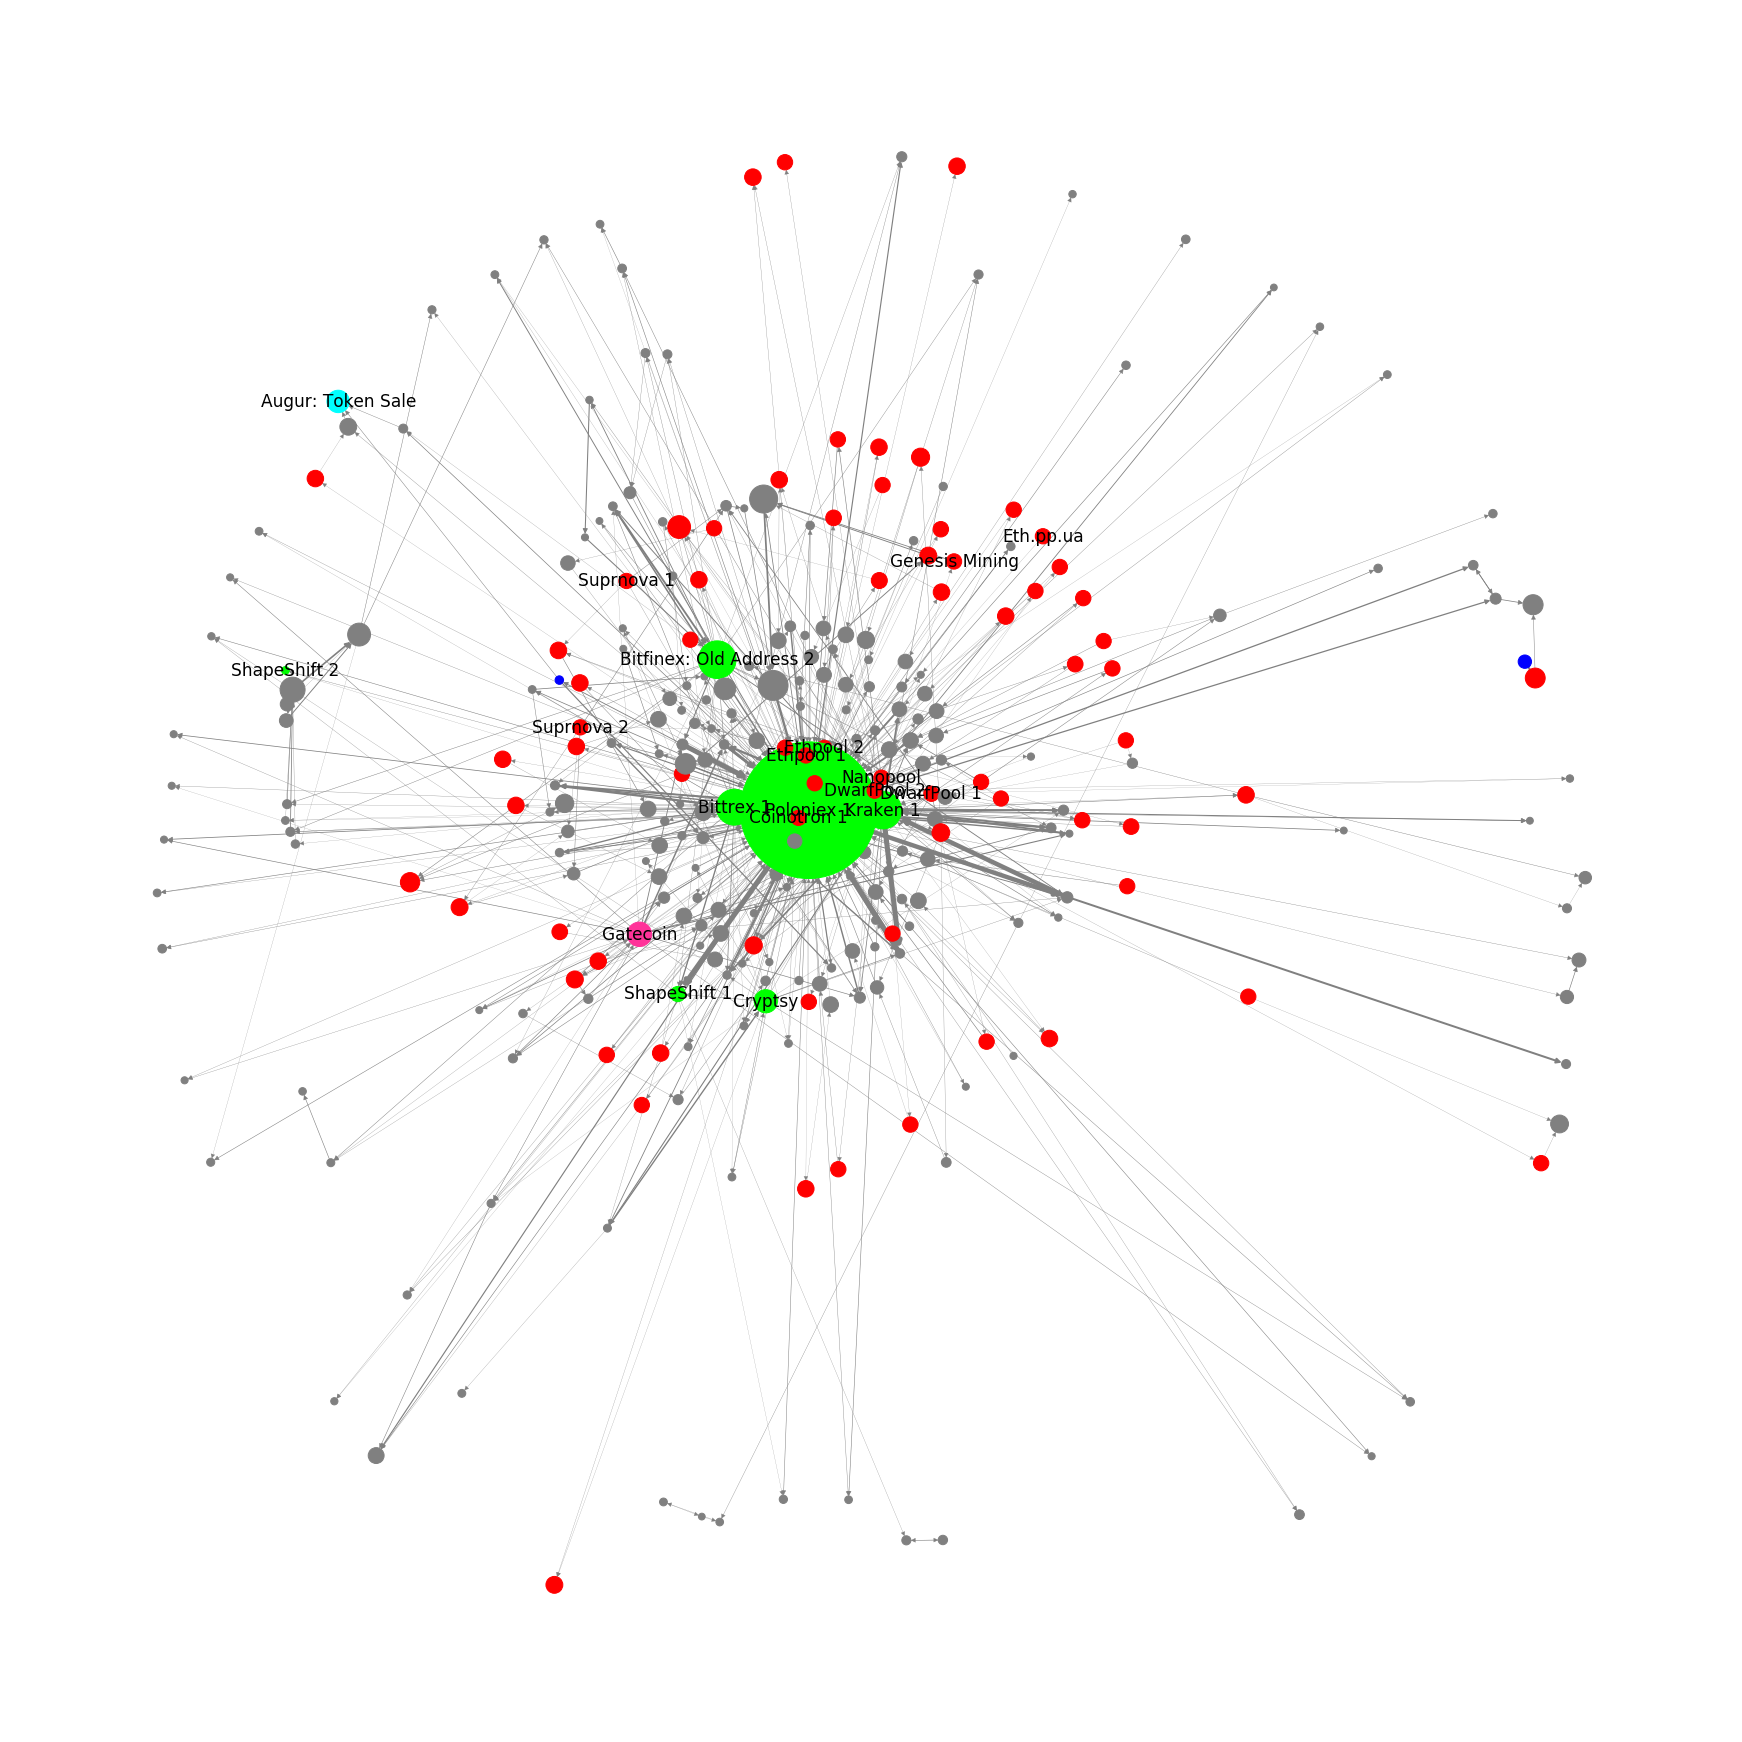

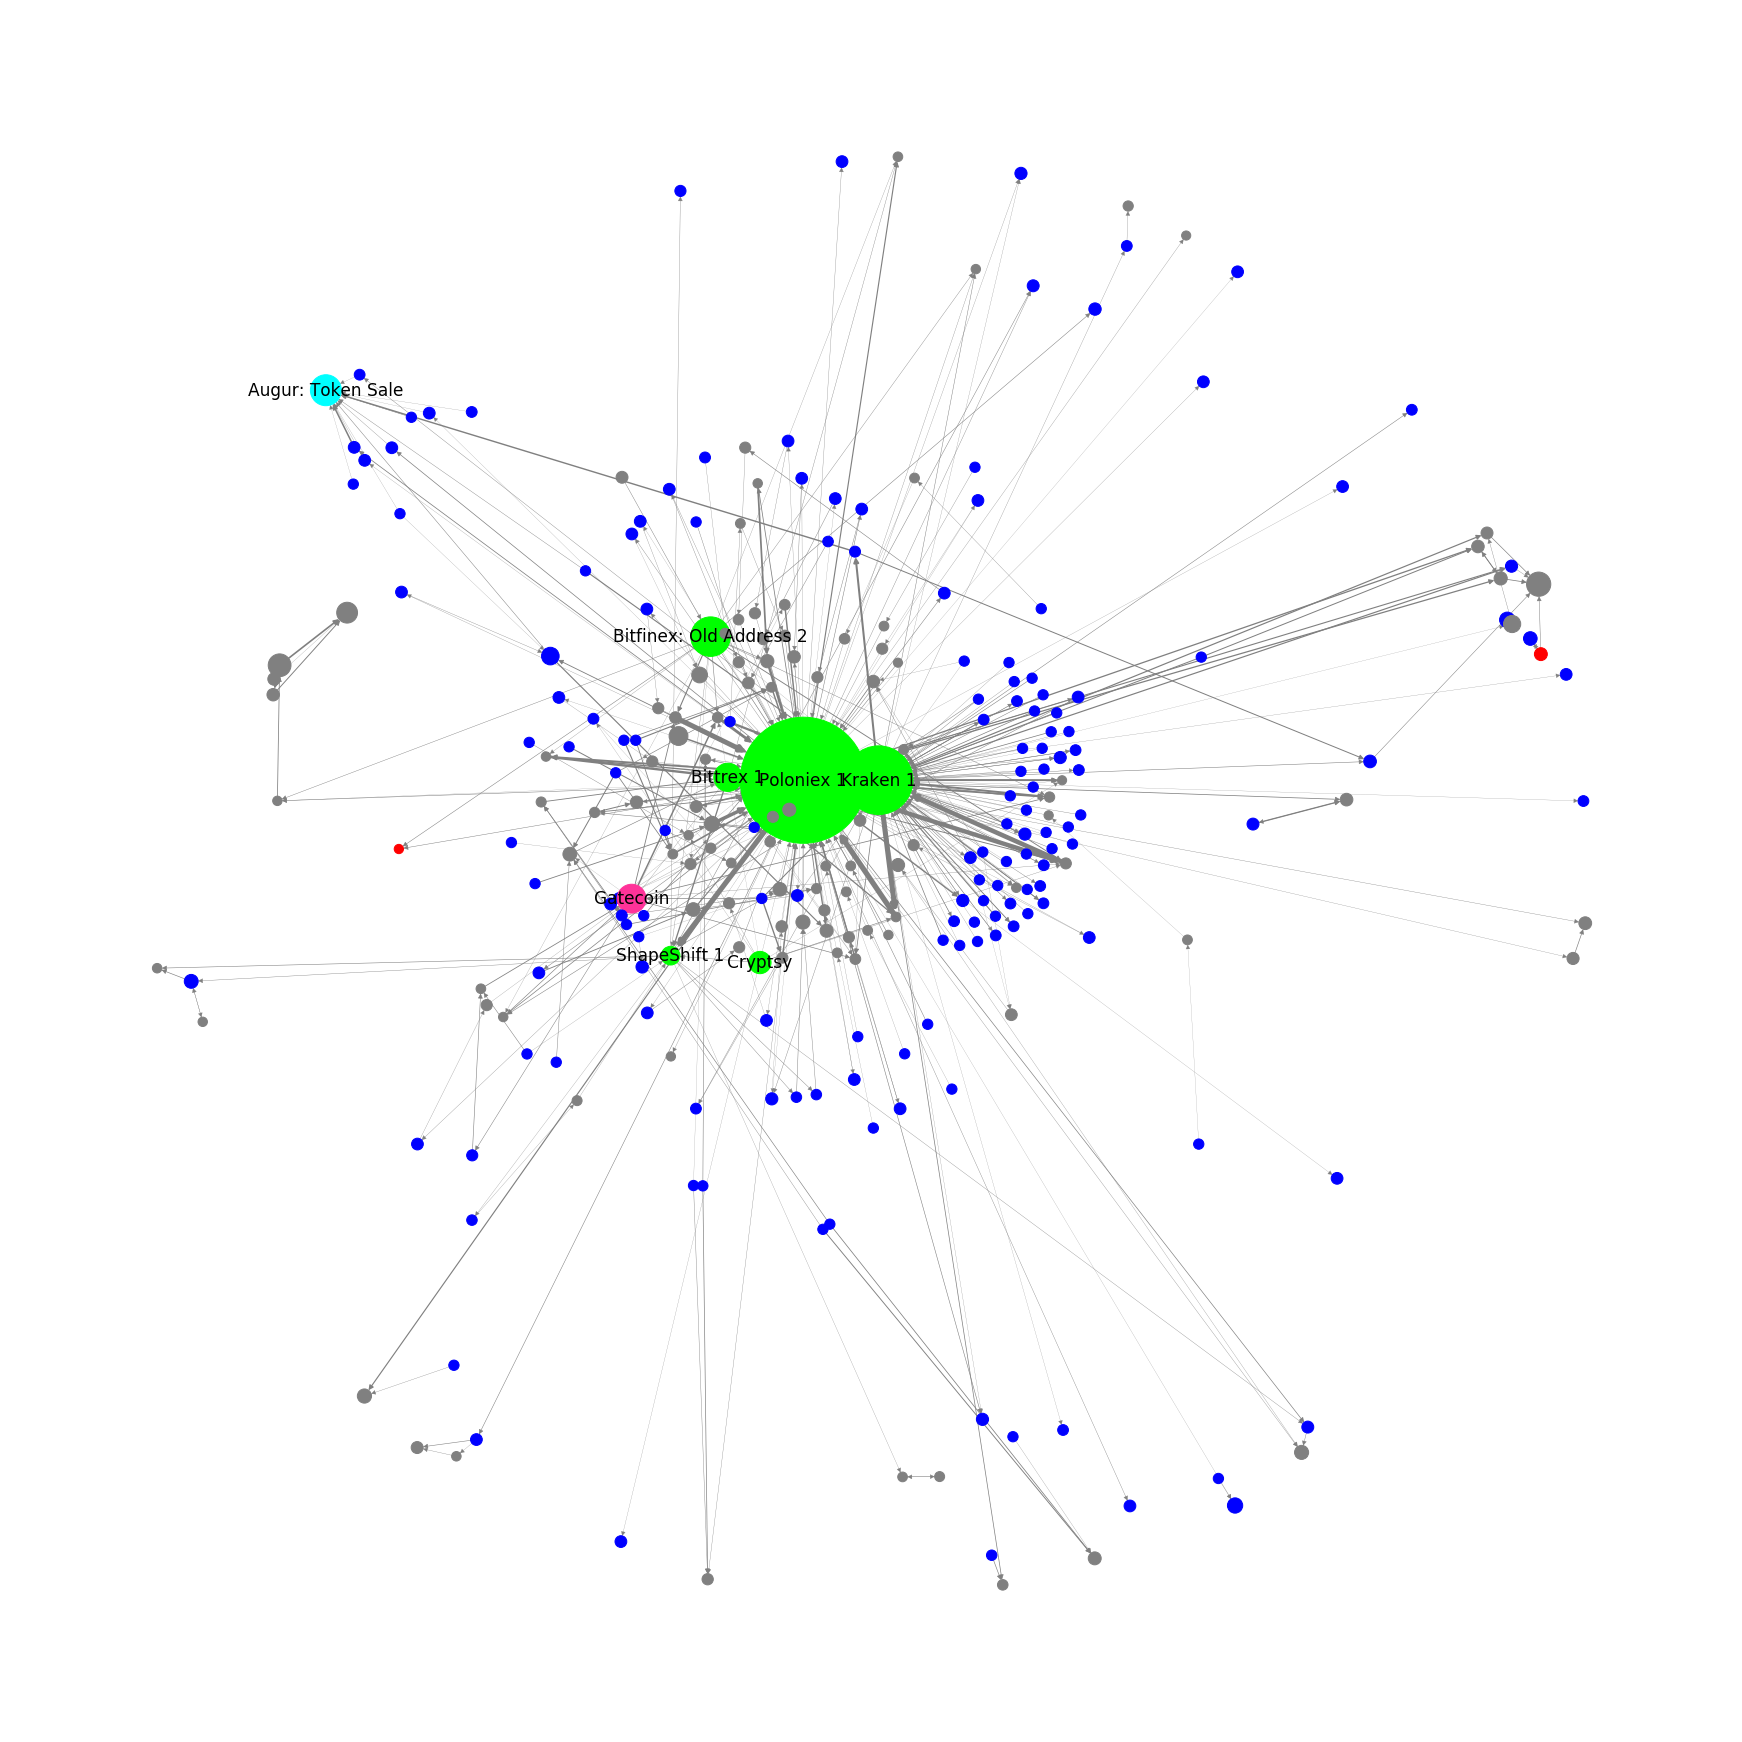

In [19]:
giant1 = delete_by_edge_threshold_and_degree(tx_G1.to_directed(), "value", 99, 2)
give_node_color(giant1)
options_giant1 = option(giant1)
# plt.figure(figsize = (24,24))
pos1 = nx.spring_layout(giant1, k=0.25, weight = "value")
# nx.draw(giant, pos = pos15, **options)
# plt.savefig("Image_files/tx_2015.png", format="PNG", dpi=1000)
# plt.show()

miner_pagerank1 = personalized_pagerank(giant1, "Miner")
miner_giant1 = give_node_threshold(giant1.to_directed(), "Minerpagerank" ,sorted(list(miner_pagerank1.values()),reverse=True)[300])
options1_miner = option_pr(miner_giant1, "Minerpagerank")

genesis_pagerank1 = personalized_pagerank(giant1, "genesis")
#genesis_giant1 = give_node_threshold(giant1.to_directed(), "genesispagerank" ,np.percentile(list(genesis_pagerank1.values()),pagerank_per))
genesis_giant1 = give_node_threshold(giant1.to_directed(), "genesispagerank" ,sorted(list(genesis_pagerank1.values()),reverse=True)[300])
options1_genesis = option_pr(genesis_giant1, "genesispagerank")

composed_giant1 = nx.compose(miner_giant1, genesis_giant1)
giant1_pos = nx.spring_layout(composed_giant1, pos = pos1, k=0.25)

plt.figure(figsize = (24,24))
nx.draw(miner_giant1, pos = giant1_pos, **options1_miner)
# plt.savefig("Image_files/tx_2015_miner.png", format="PNG", bbox_inches='tight', dpi=1000)
plt.show()

plt.figure(figsize = (24,24))
nx.draw(genesis_giant1, pos = giant1_pos, **options1_genesis)
# plt.savefig("Image_files/tx_2015_genesis.png", format="PNG", bbox_inches='tight', dpi=1000)
plt.show()

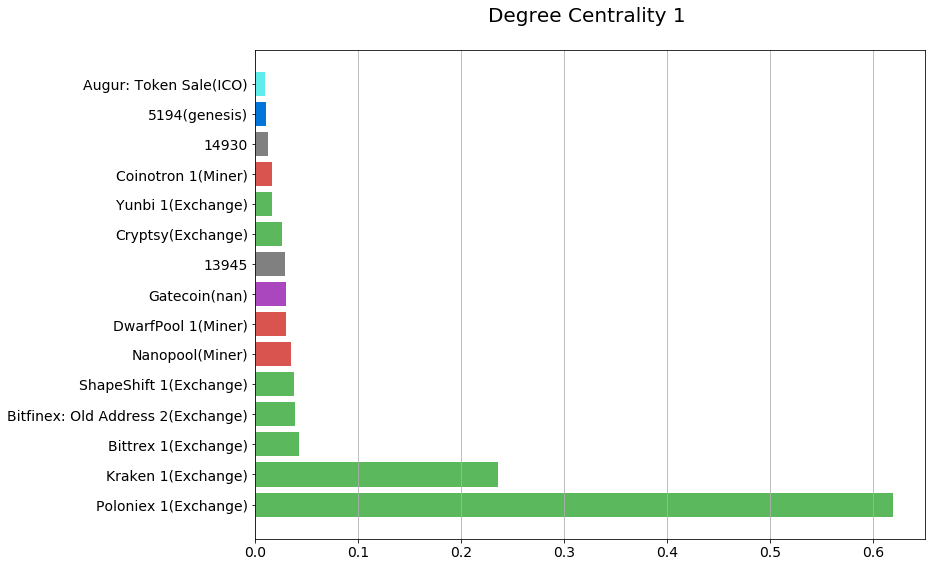

Text(0.5, 1.0, 'Genesis Personalized PageRank 2015-2016.04 \n')

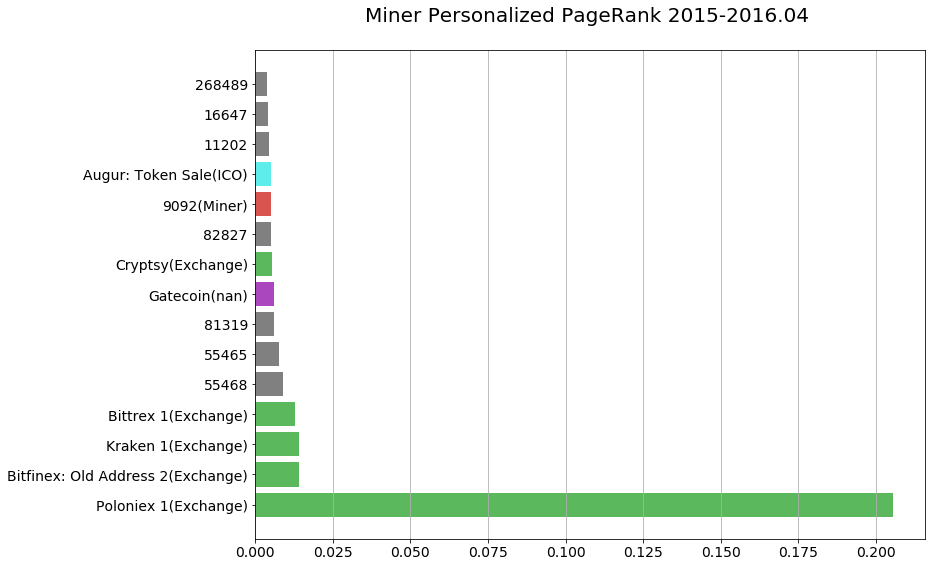

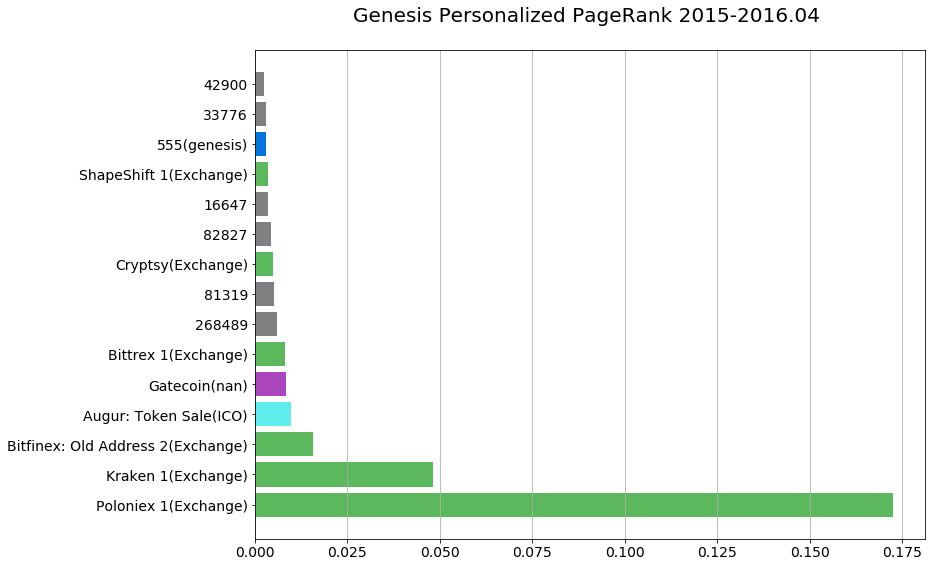

In [7]:
degree_centrality1 = nx.degree_centrality(giant1)
sorted_dc1 = sorted(degree_centrality1.items(), key=(lambda x: x[1]), reverse = True)

nametag1 = nx.get_node_attributes(giant1,"nametag")
type_1 = nx.get_node_attributes(giant1,"type")
give_node_deep_color(giant1)
deep_color1 = nx.get_node_attributes(giant1,"deep_color")

x_dc_1, y_dc_1, c_dc_1 = select_top15(sorted_dc1, nametag1, type_1, deep_color1)

plt.figure(figsize = (12,9))
plt.barh(x_dc_1, y_dc_1, color = c_dc_1)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(which = "both", axis = "x")
plt.title("Degree Centrality 1 \n", fontsize = 20)
# plt.savefig("Image_files/dc_2015.png", format="PNG", bbox_inches='tight', dpi=200)
plt.show()


sorted_mpr1 = sorted(miner_pagerank1.items(), key=(lambda x: x[1]), reverse = True)

x_mpr_1, y_mpr_1, c_mpr_1 = select_top15(sorted_mpr1, nametag1, type_1, deep_color1)

plt.figure(figsize = (12,9))
plt.barh(x_mpr_1, y_mpr_1, color = c_mpr_1)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(which = "both", axis = "x")
plt.title("Miner Personalized PageRank 2015-2016.04 \n", fontsize = 20)
# plt.savefig("Image_files/mPPR_2015.png", format="PNG", bbox_inches='tight', dpi=200)

sorted_gpr1 = sorted(genesis_pagerank1.items(), key=(lambda x: x[1]), reverse = True)

x_gpr_1, y_gpr_1, c_gpr_1  = select_top15(sorted_gpr1, nametag1, type_1, deep_color1)

plt.figure(figsize = (12,9))
plt.barh(x_gpr_1, y_gpr_1, color = c_gpr_1)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(which = "both", axis = "x")
plt.title("Genesis Personalized PageRank 2015-2016.04 \n", fontsize = 20)
# plt.savefig("Image_files/gPPR_2015.png", format="PNG", bbox_inches='tight', dpi=200)

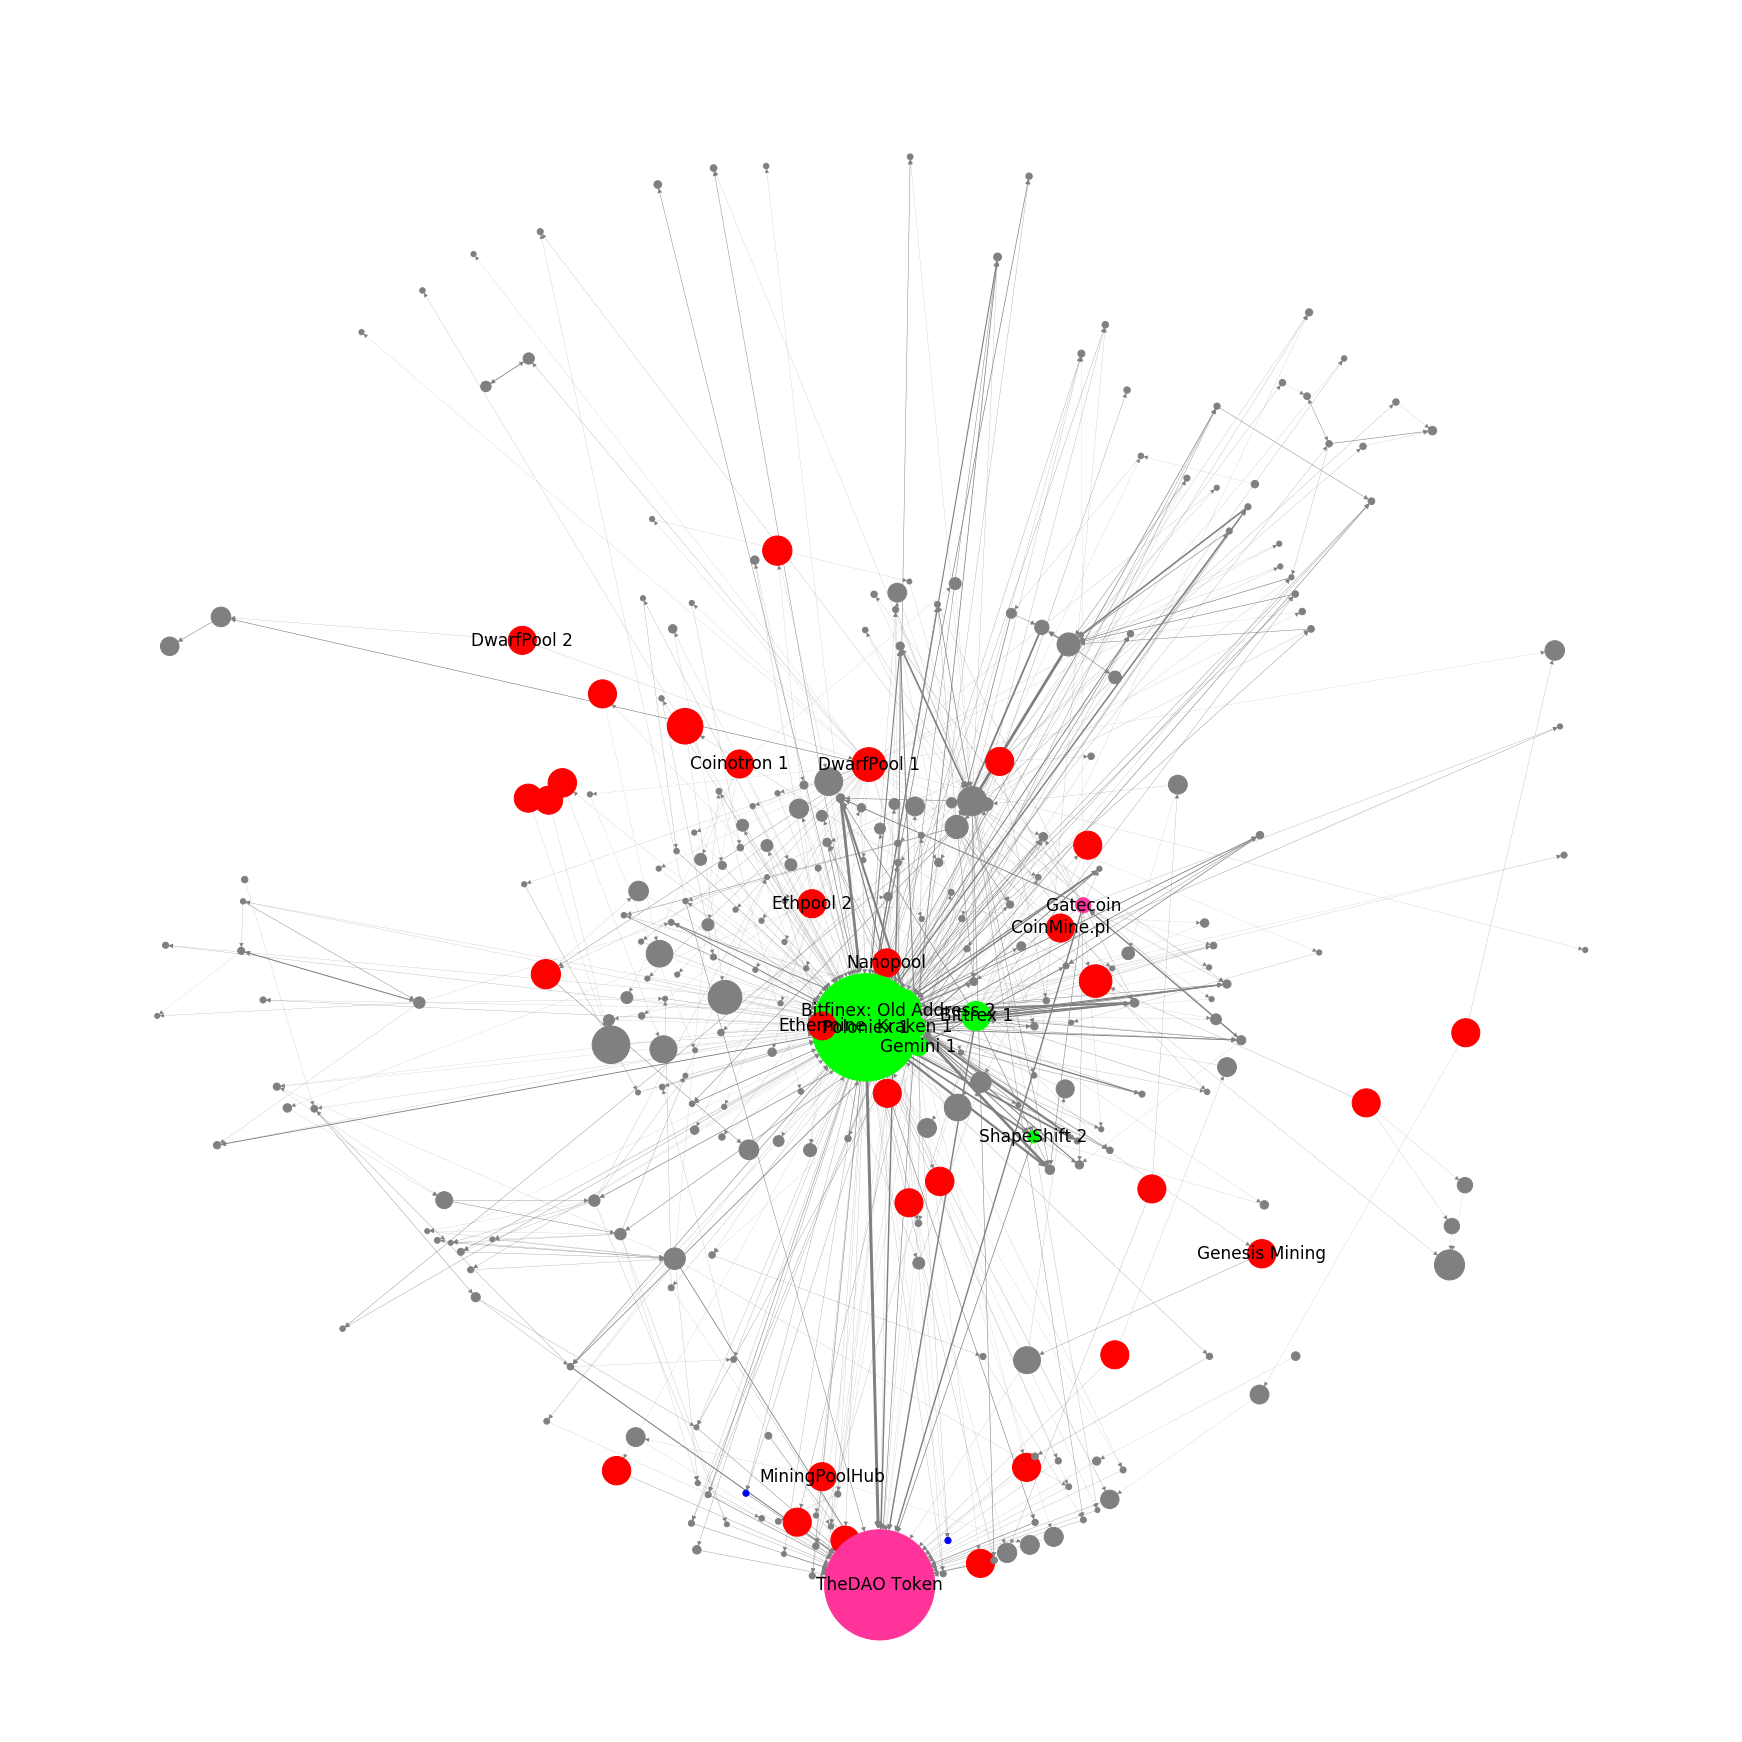

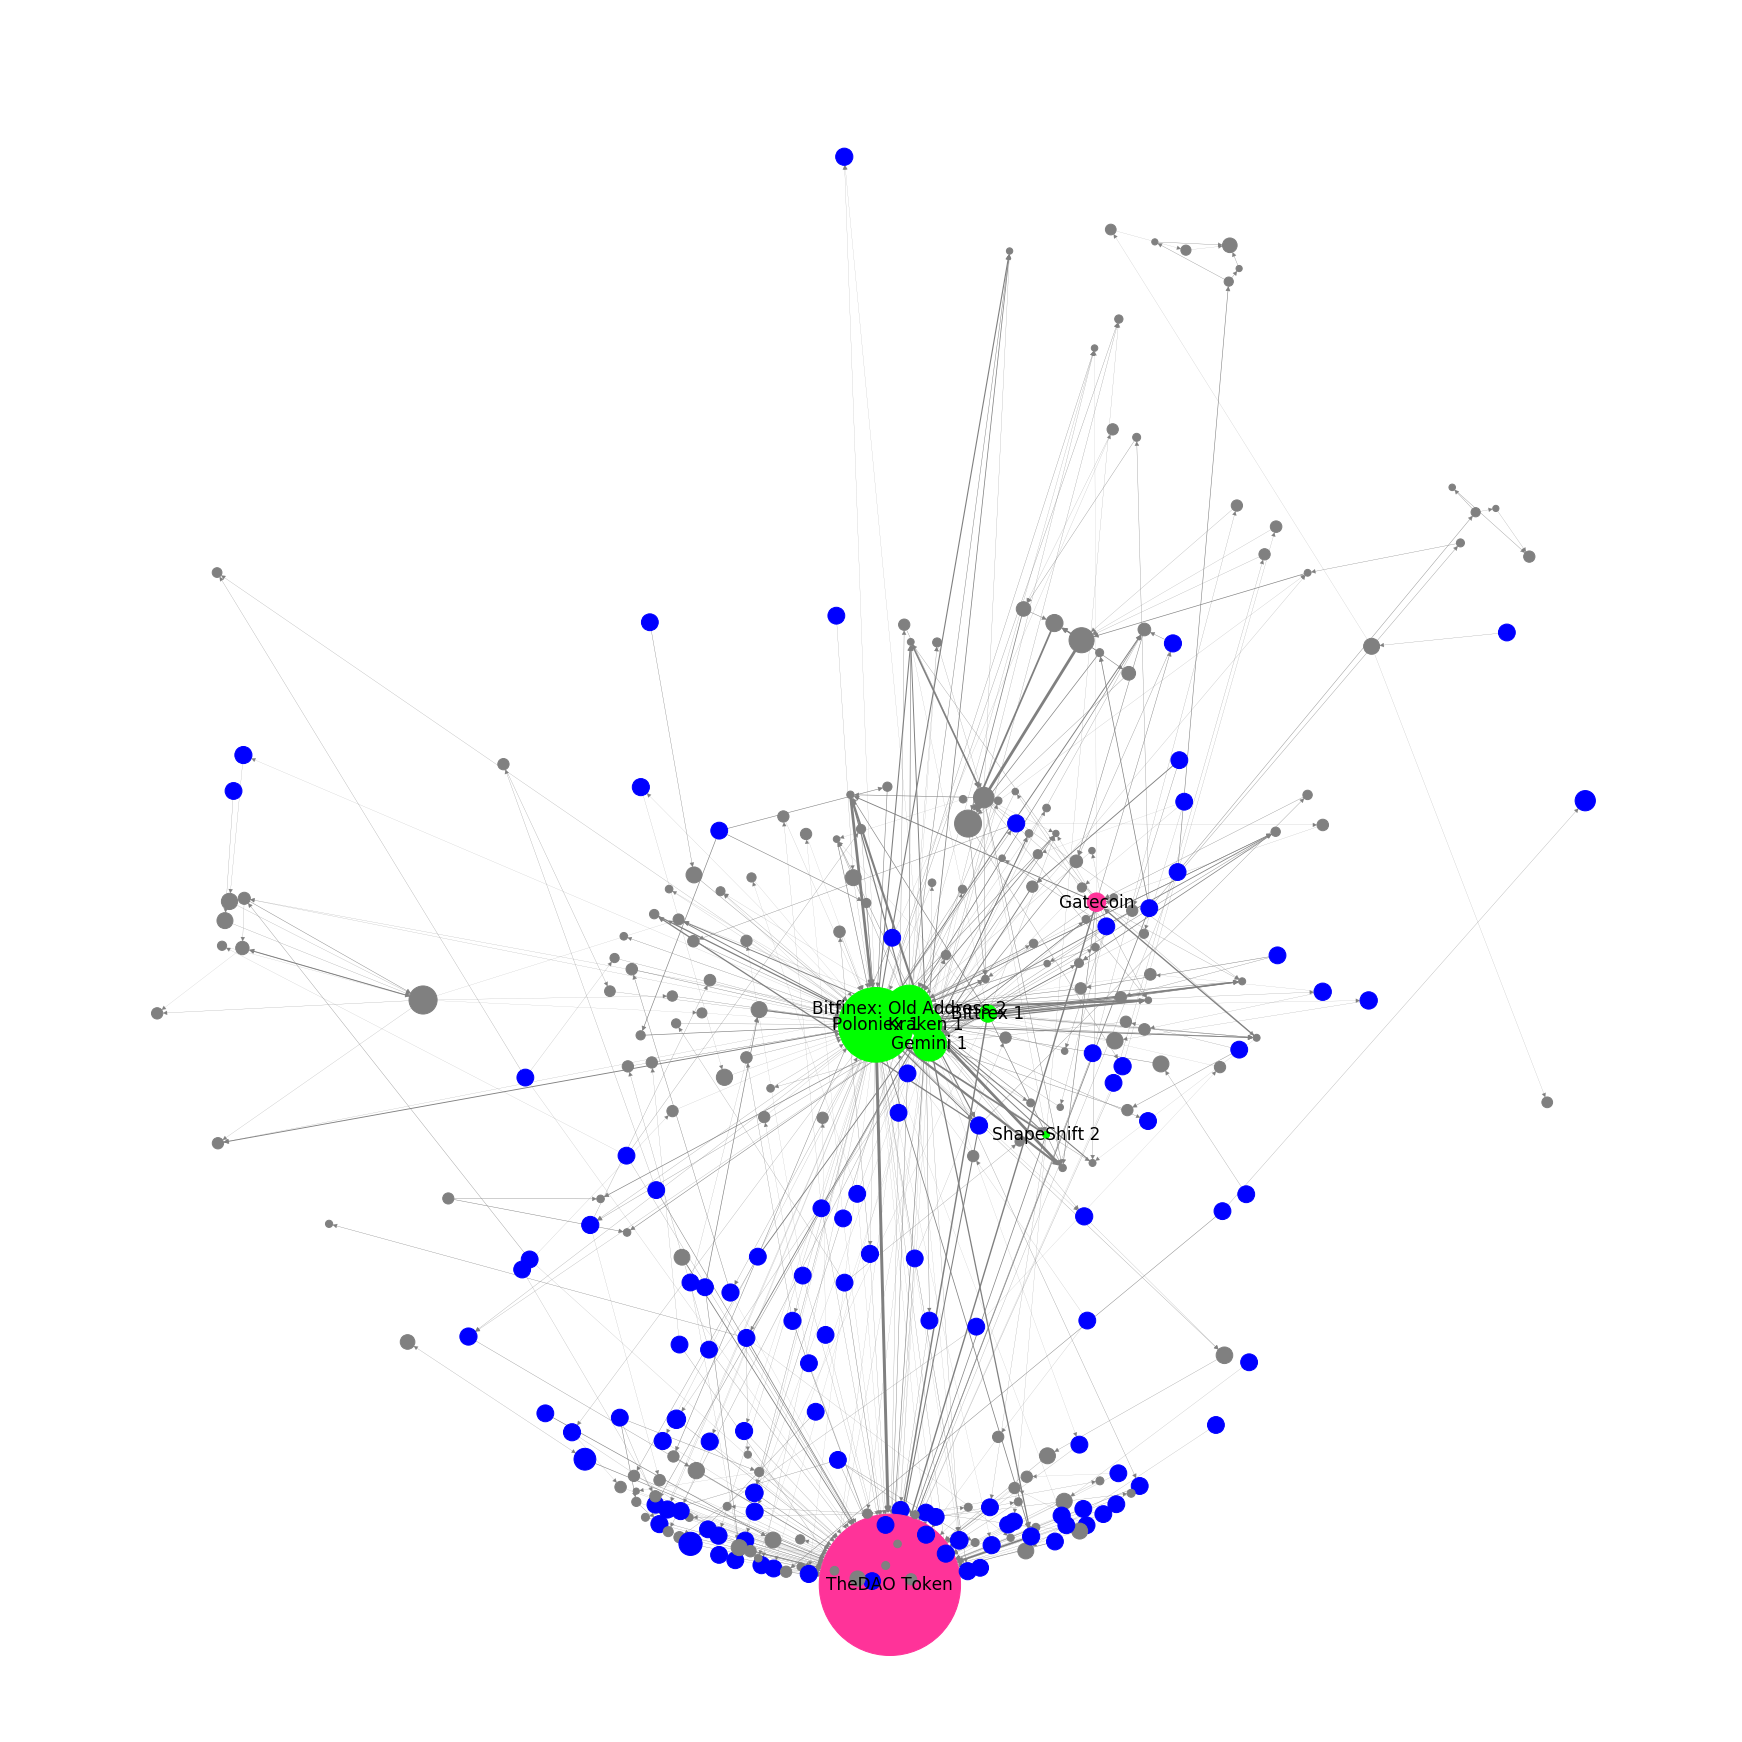

In [20]:
giant2 = delete_by_edge_threshold_and_degree(tx_G2.to_directed(), "value", 99, 2)

give_node_color(giant2)
options = option(giant2)
# plt.figure(figsize = (24,24))
pos2 = nx.spring_layout(giant2, k=0.25, weight = "value")
# nx.draw(giant, pos = pos15, **options)
# plt.savefig("Image_files/tx_2015.png", format="PNG", dpi=1000)
# plt.show()

miner_pagerank2 = personalized_pagerank(giant2, "Miner")
miner_giant2 = give_node_threshold(giant2.to_directed(), "Minerpagerank" ,sorted(list(miner_pagerank2.values()),reverse=True)[300])
options2_miner = option_pr(miner_giant2, "Minerpagerank")

genesis_pagerank2 = personalized_pagerank(giant2, "genesis")
genesis_giant2 = give_node_threshold(giant2.to_directed(), "genesispagerank" ,sorted(list(genesis_pagerank2.values()),reverse=True)[300])
options2_genesis = option_pr(genesis_giant2, "genesispagerank")

composed_giant2 = nx.compose(miner_giant2, genesis_giant2)
giant2_pos = nx.spring_layout(composed_giant2, pos = pos2, k=0.25)

plt.figure(figsize = (24,24))
nx.draw(miner_giant2, pos = giant2_pos, **options2_miner)
# plt.savefig("Image_files/tx_2015_miner.png", format="PNG", bbox_inches='tight', dpi=1000)
plt.show()

plt.figure(figsize = (24,24))
nx.draw(genesis_giant2, pos = giant2_pos, **options2_genesis)
# plt.savefig("Image_files/tx_2015_genesis.png", format="PNG", bbox_inches='tight', dpi=1000)
plt.show()

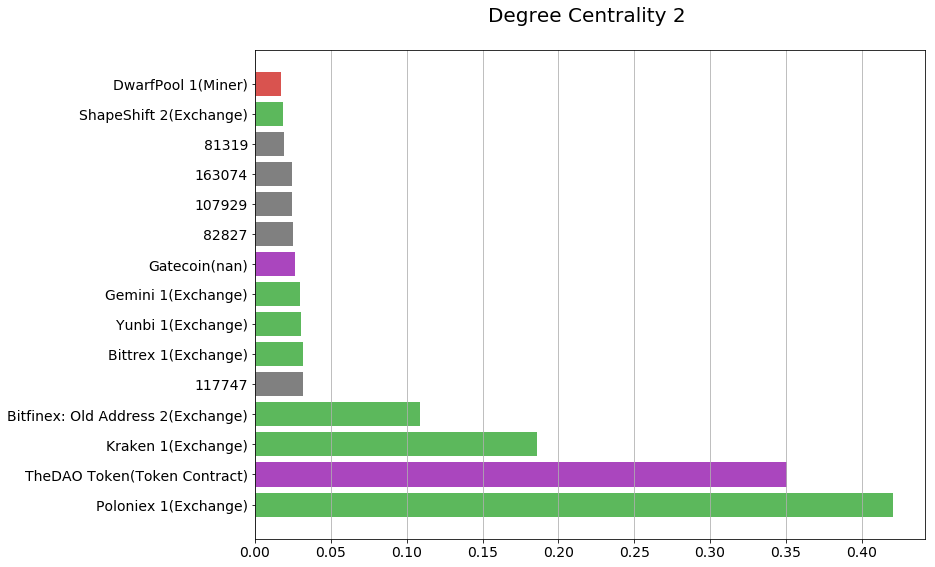

Text(0.5, 1.0, 'Genesis Personalized PageRank 2016.05-2016.06.16 \n')

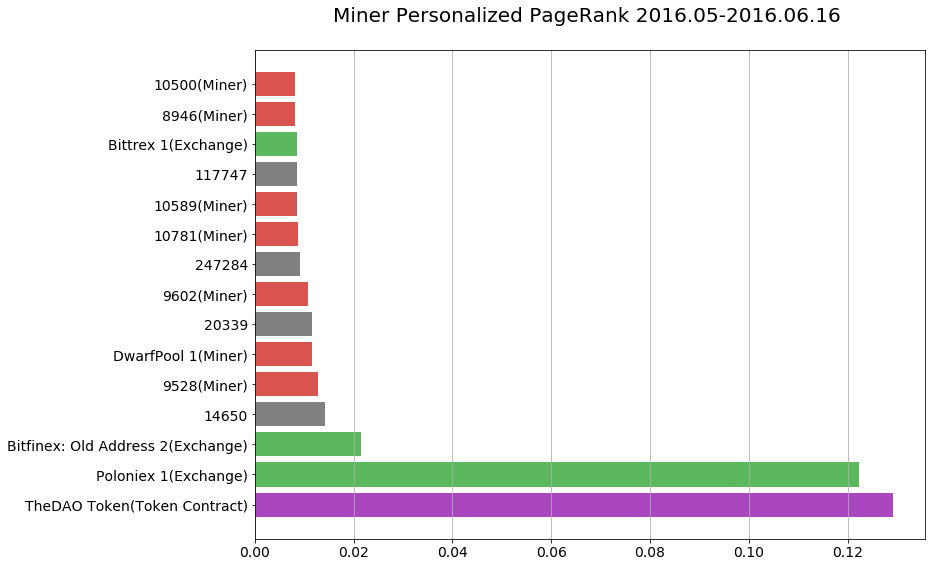

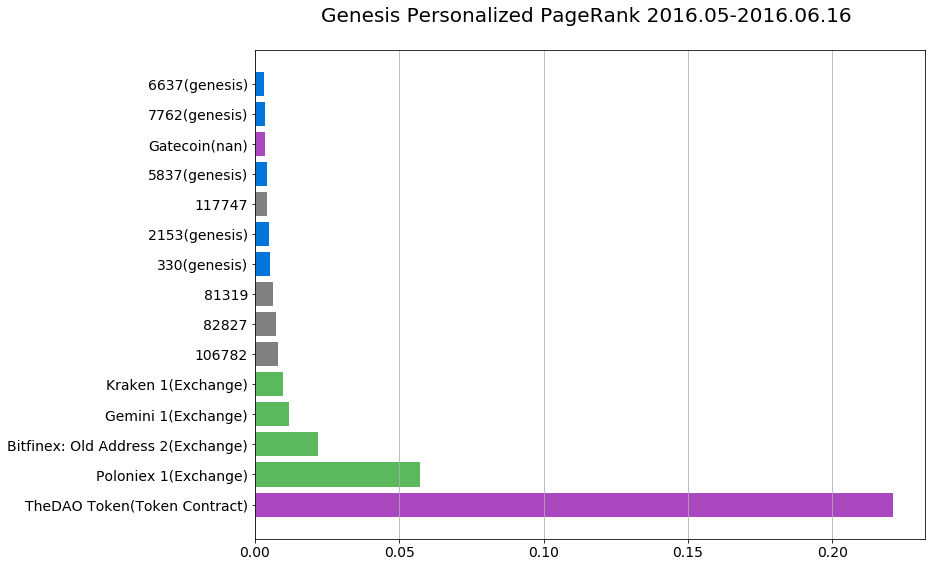

In [9]:
degree_centrality2 = nx.degree_centrality(giant2)
sorted_dc2 = sorted(degree_centrality2.items(), key=(lambda x: x[1]), reverse = True)

nametag2 = nx.get_node_attributes(giant2,"nametag")
type_2 = nx.get_node_attributes(giant2,"type")
give_node_deep_color(giant2)
deep_color2 = nx.get_node_attributes(giant2,"deep_color")

x_dc_2, y_dc_2, c_dc_2 = select_top15(sorted_dc2, nametag2, type_2, deep_color2)

plt.figure(figsize = (12,9))
plt.barh(x_dc_2, y_dc_2, color = c_dc_2)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(which = "both", axis = "x")
plt.title("Degree Centrality 2 \n", fontsize = 20)
# plt.savefig("Image_files/dc_2015.png", format="PNG", bbox_inches='tight', dpi=200)
plt.show()



sorted_mpr2 = sorted(miner_pagerank2.items(), key=(lambda x: x[1]), reverse = True)

x_mpr_2, y_mpr_2, c_mpr_2 = select_top15(sorted_mpr2, nametag2, type_2, deep_color2)

plt.figure(figsize = (12,9))
plt.barh(x_mpr_2, y_mpr_2, color = c_mpr_2)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(which = "both", axis = "x")
plt.title("Miner Personalized PageRank 2016.05-2016.06.16 \n", fontsize = 20)
# plt.savefig("Image_files/mPPR_2015.png", format="PNG", bbox_inches='tight', dpi=200)

sorted_gpr2 = sorted(genesis_pagerank2.items(), key=(lambda x: x[1]), reverse = True)

x_gpr_2, y_gpr_2, c_gpr_2  = select_top15(sorted_gpr2, nametag2, type_2, deep_color2)

plt.figure(figsize = (12,9))
plt.barh(x_gpr_2, y_gpr_2, color = c_gpr_2)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(which = "both", axis = "x")
plt.title("Genesis Personalized PageRank 2016.05-2016.06.16 \n", fontsize = 20)
# plt.savefig("Image_files/gPPR_2015.png", format="PNG", bbox_inches='tight', dpi=200)

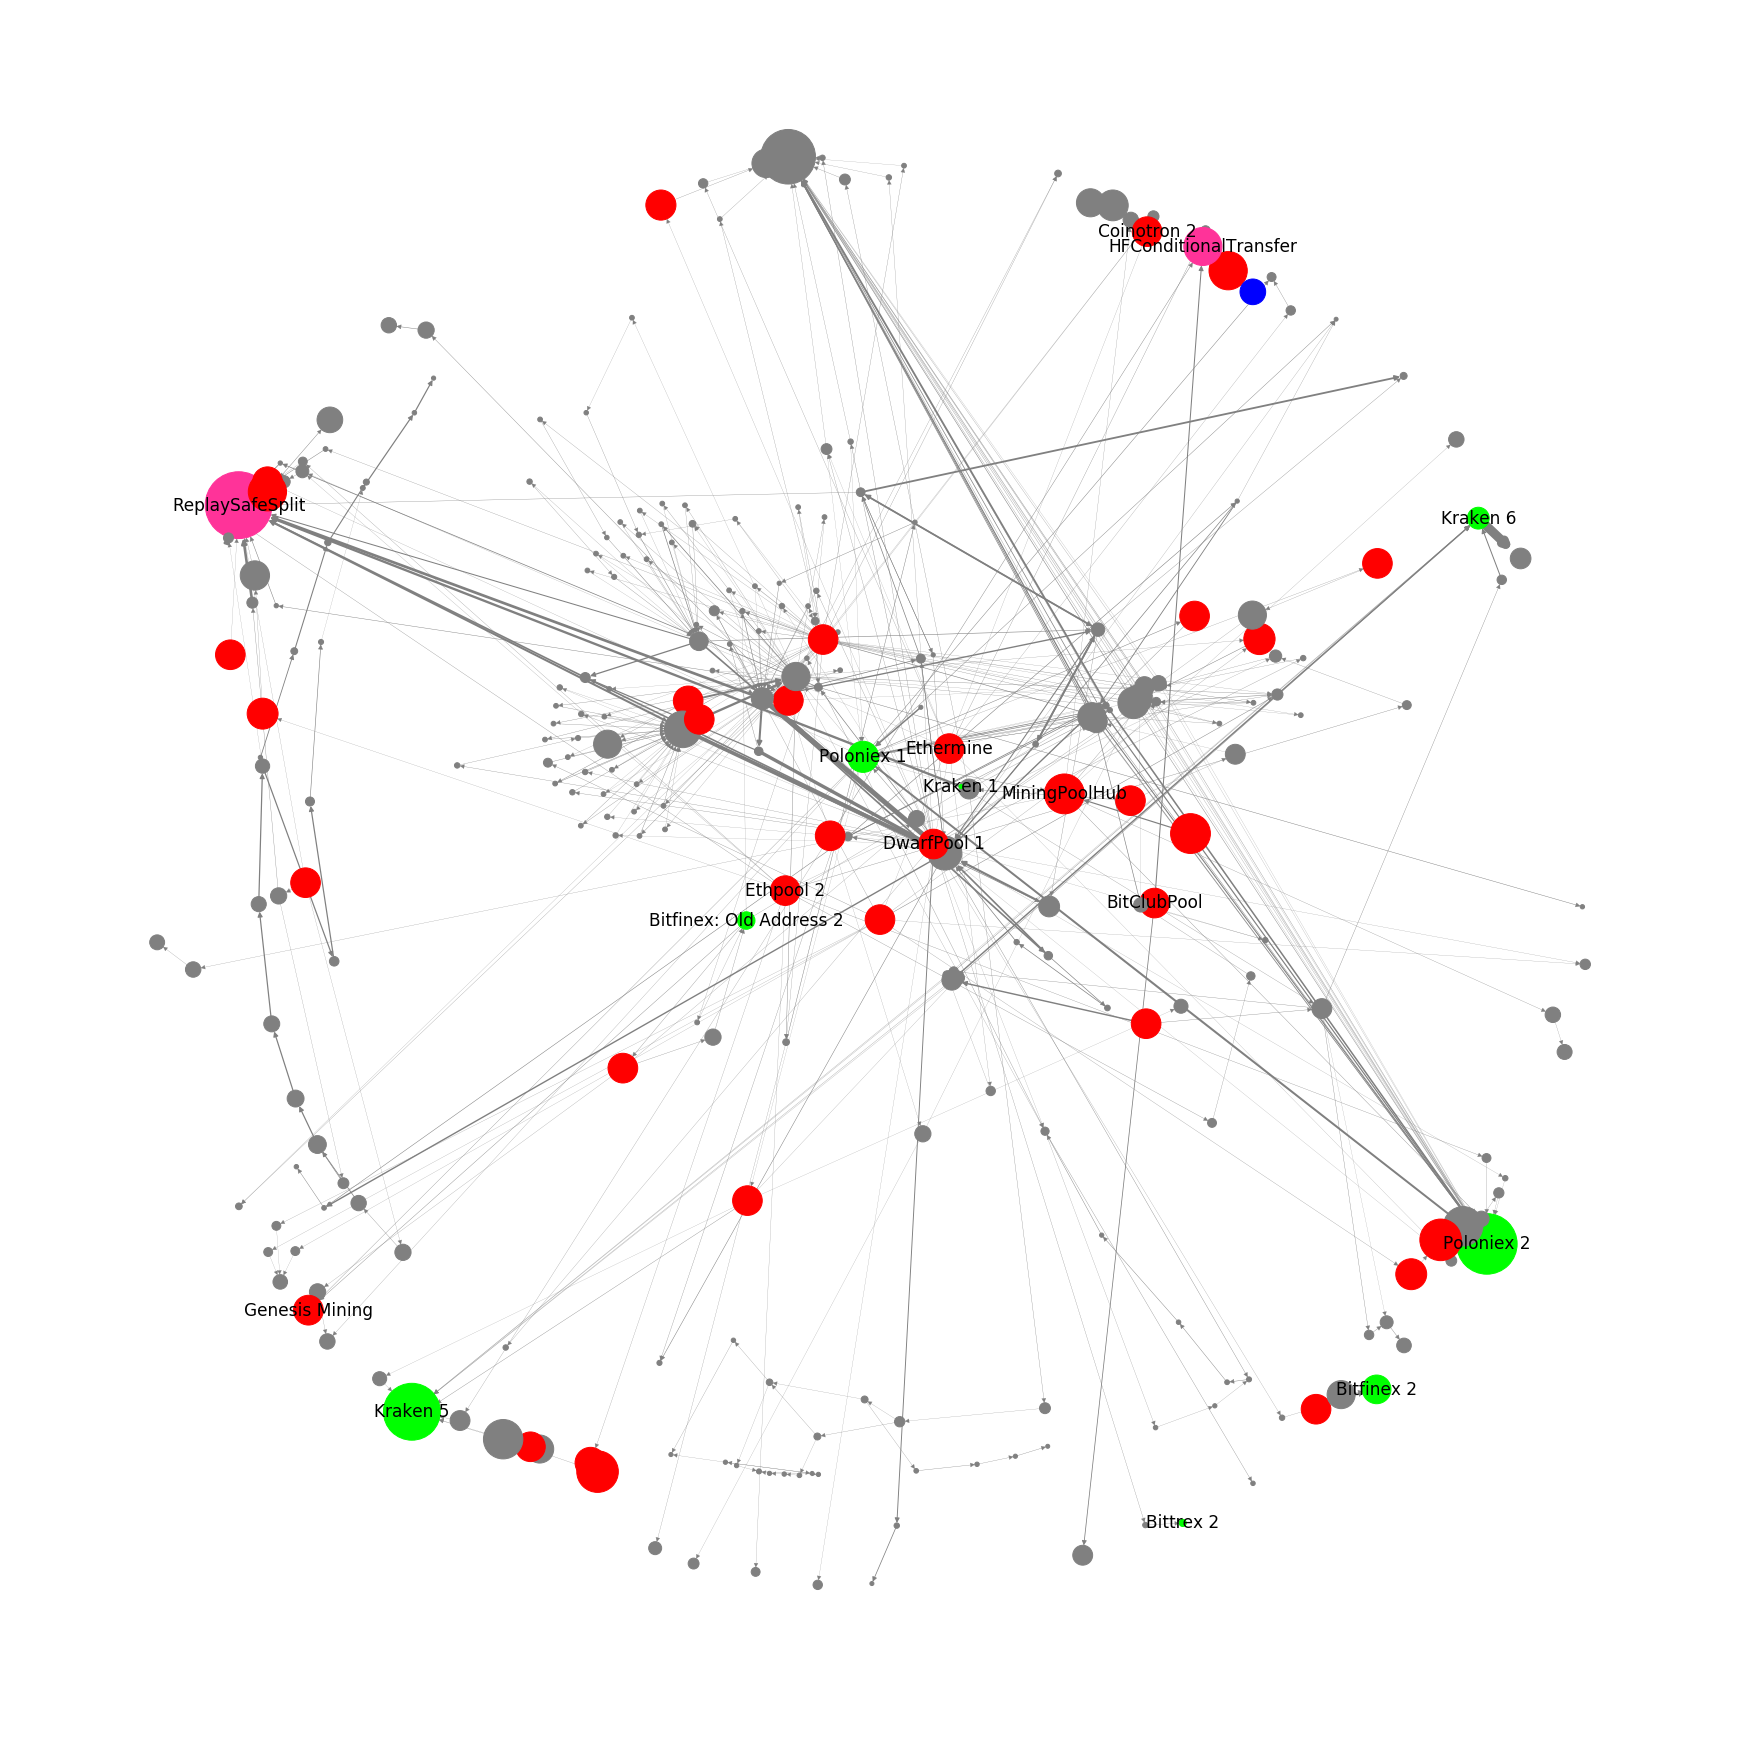

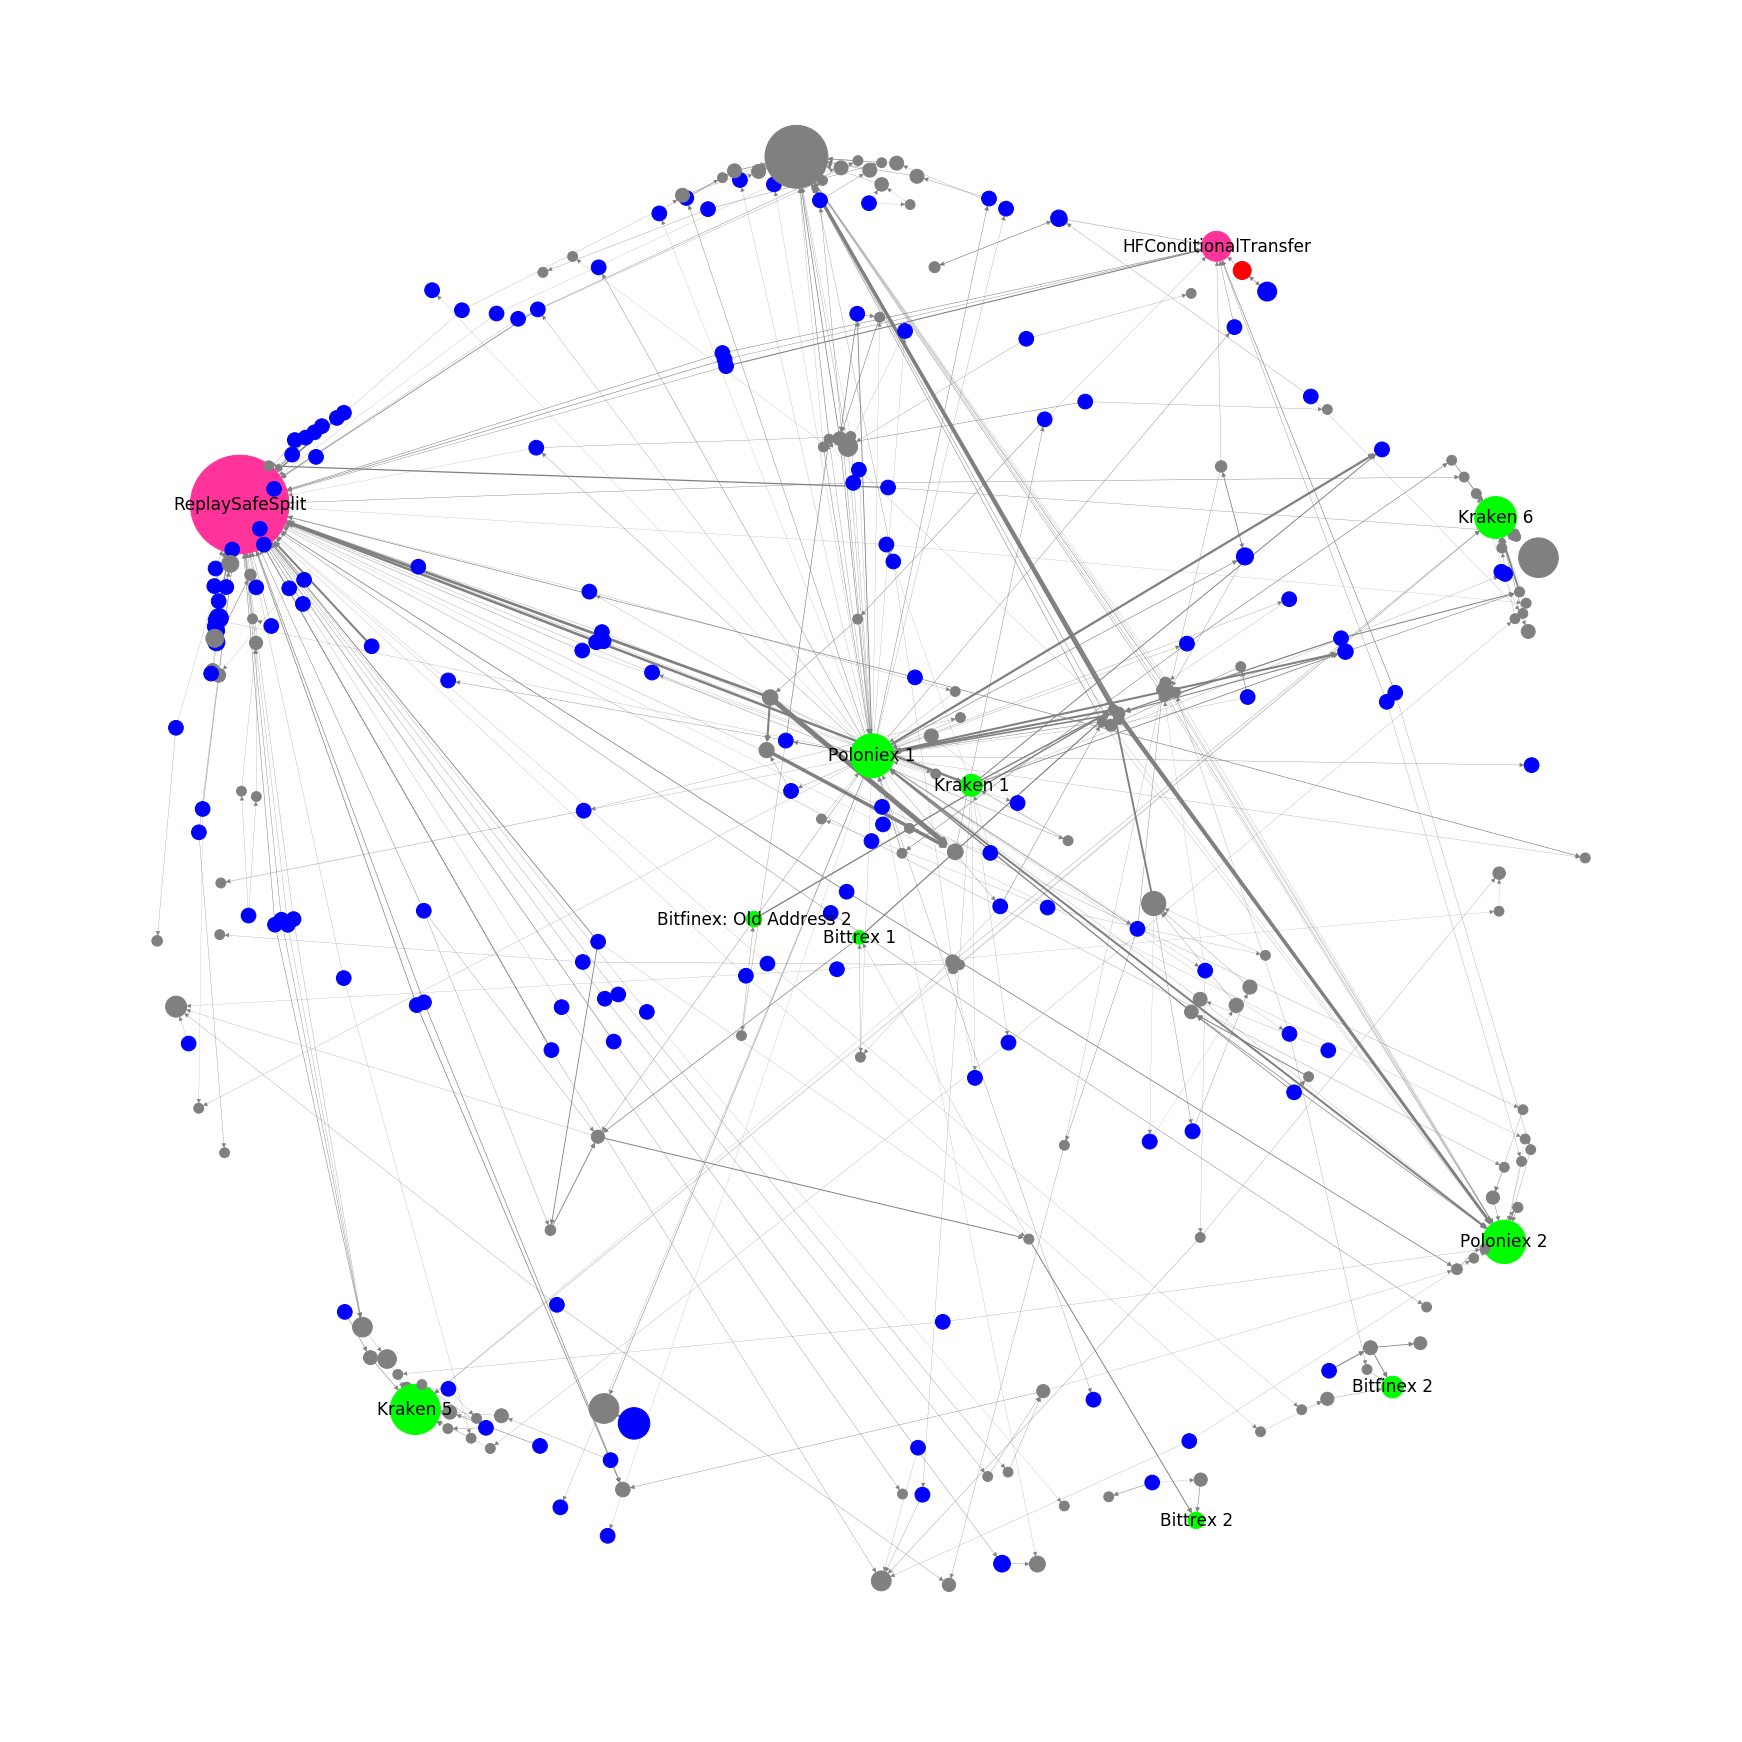

In [21]:
giant3 = delete_by_edge_threshold_and_degree(tx_G3.to_directed(), "value", 99, 2)

give_node_color(giant3)
options = option(giant3)
# plt.figure(figsize = (24,24))
pos3 = nx.spring_layout(giant3, k=0.25, weight = "value")
# nx.draw(giant, pos = pos15, **options)
# plt.savefig("Image_files/tx_2015.png", format="PNG", dpi=1000)
# plt.show()

miner_pagerank3 = personalized_pagerank(giant3, "Miner")
miner_giant3 = give_node_threshold(giant3.to_directed(), "Minerpagerank" ,sorted(list(miner_pagerank3.values()),reverse=True)[300])
options3_miner = option_pr(miner_giant3, "Minerpagerank")

genesis_pagerank3 = personalized_pagerank(giant3, "genesis")
genesis_giant3 = give_node_threshold(giant3.to_directed(), "genesispagerank" ,sorted(list(genesis_pagerank3.values()),reverse=True)[300])
options3_genesis = option_pr(genesis_giant3, "genesispagerank")

composed_giant3 = nx.compose(miner_giant3, genesis_giant3)
giant3_pos = nx.spring_layout(composed_giant3, pos = pos3, k=0.25)

plt.figure(figsize = (24,24))
nx.draw(miner_giant3, pos = giant3_pos, **options3_miner)
# plt.savefig("Image_files/tx_2015_miner.png", format="PNG", bbox_inches='tight', dpi=1000)
plt.show()

plt.figure(figsize = (24,24))
nx.draw(genesis_giant3, pos = giant3_pos, **options3_genesis)
# plt.savefig("Image_files/tx_2015_genesis.png", format="PNG", bbox_inches='tight', dpi=1000)
plt.show()

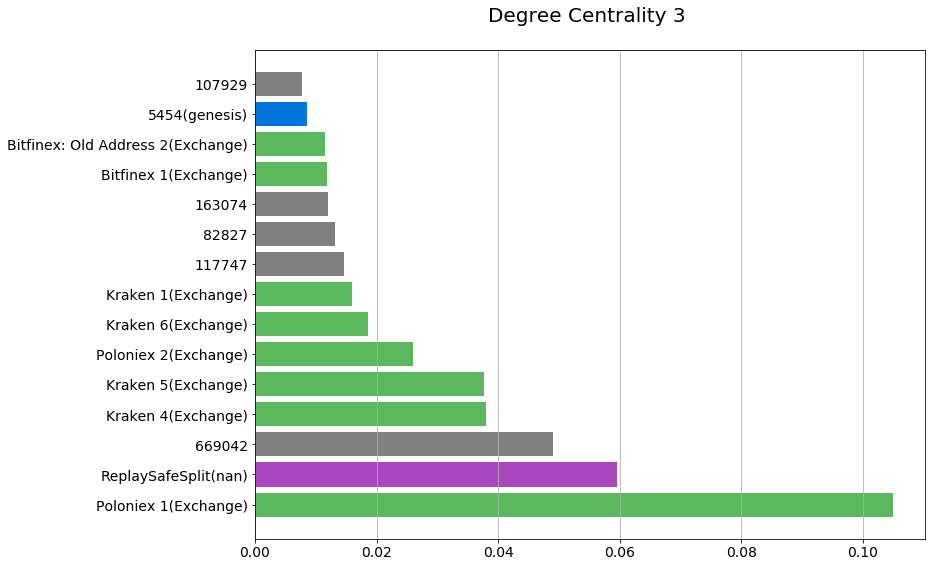

Text(0.5, 1.0, 'Genesis Personalized PageRank 2016.06.16-2016.12 \n')

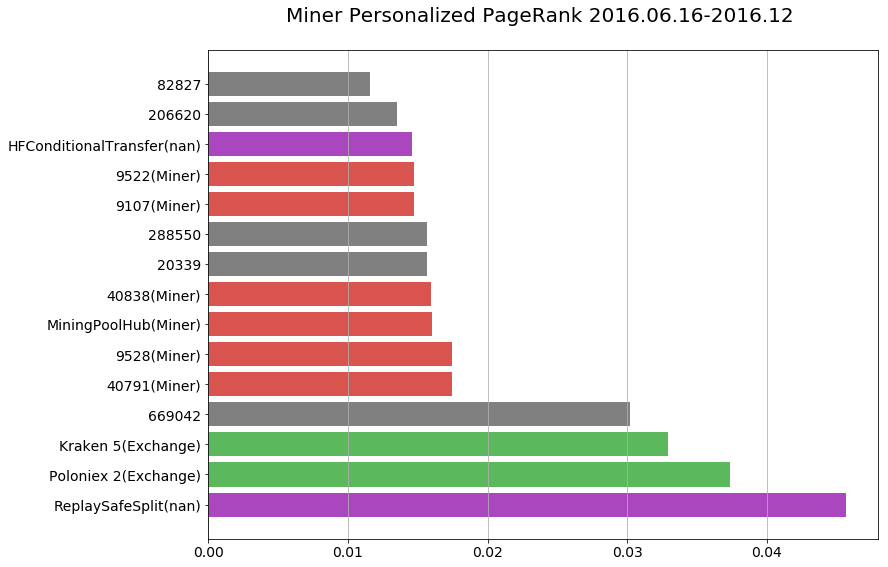

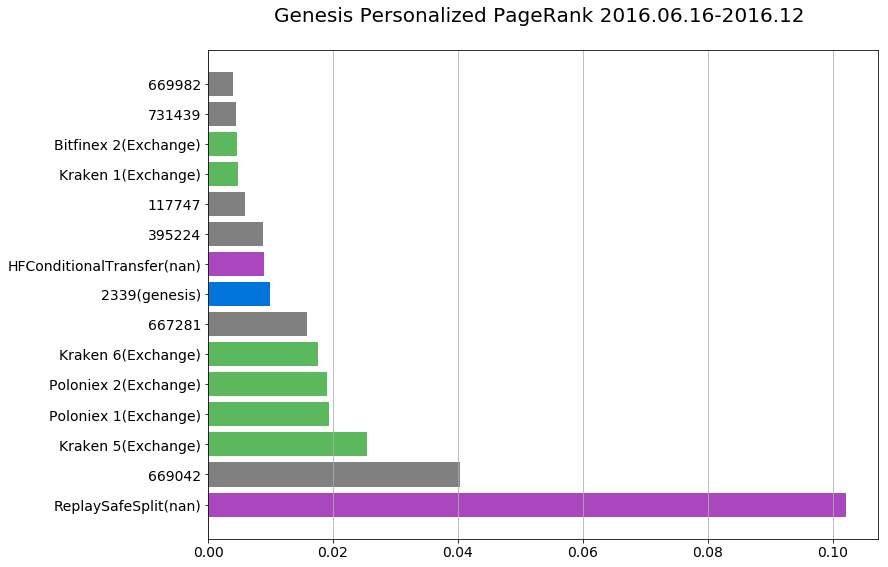

In [11]:
degree_centrality3 = nx.degree_centrality(giant3)
sorted_dc3 = sorted(degree_centrality3.items(), key=(lambda x: x[1]), reverse = True)

nametag3 = nx.get_node_attributes(giant3,"nametag")
type_3 = nx.get_node_attributes(giant3,"type")
give_node_deep_color(giant3)
deep_color3 = nx.get_node_attributes(giant3,"deep_color")

x_dc_3, y_dc_3, c_dc_3 = select_top15(sorted_dc3, nametag3, type_3, deep_color3)

plt.figure(figsize = (12,9))
plt.barh(x_dc_3, y_dc_3, color = c_dc_3)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(which = "both", axis = "x")
plt.title("Degree Centrality 3 \n", fontsize = 20)
# plt.savefig("Image_files/dc_2015.png", format="PNG", bbox_inches='tight', dpi=200)
plt.show()



sorted_mpr3 = sorted(miner_pagerank3.items(), key=(lambda x: x[1]), reverse = True)

x_mpr_3, y_mpr_3, c_mpr_3 = select_top15(sorted_mpr3, nametag3, type_3, deep_color3)

plt.figure(figsize = (12,9))
plt.barh(x_mpr_3, y_mpr_3, color = c_mpr_3)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(which = "both", axis = "x")
plt.title("Miner Personalized PageRank 2016.06.16-2016.12 \n", fontsize = 20)
# plt.savefig("Image_files/mPPR_2015.png", format="PNG", bbox_inches='tight', dpi=200)

sorted_gpr3 = sorted(genesis_pagerank3.items(), key=(lambda x: x[1]), reverse = True)

x_gpr_3, y_gpr_3, c_gpr_3  = select_top15(sorted_gpr3, nametag3, type_3, deep_color3)

plt.figure(figsize = (12,9))
plt.barh(x_gpr_3, y_gpr_3, color = c_gpr_3)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(which = "both", axis = "x")
plt.title("Genesis Personalized PageRank 2016.06.16-2016.12 \n", fontsize = 20)
# plt.savefig("Image_files/gPPR_2015.png", format="PNG", bbox_inches='tight', dpi=200)

# Statistics

In [12]:
print('--------------------original network------------------------')
print(nx.number_of_nodes(tx_G1))
print(nx.number_of_nodes(tx_G2))
print(nx.number_of_nodes(tx_G3))
print('--------------------------------------------')
print(nx.number_of_edges(tx_G1))
print(nx.number_of_edges(tx_G2))
print(nx.number_of_edges(tx_G3))
print('--------------------------------------------')
print('--------------------------------------------')

print('--------------------reduced network------------------------')
print(nx.number_of_nodes(giant1))
print(nx.number_of_nodes(giant2))
print(nx.number_of_nodes(giant3))
print('--------------------------------------------')
print(nx.number_of_edges(giant1))
print(nx.number_of_edges(giant2))
print(nx.number_of_edges(giant3))
print('--------------------------------------------')
print('--------------------------------------------')

print('--------------------miner network------------------------')
print(nx.number_of_nodes(miner_giant1))
print(nx.number_of_nodes(miner_giant2))
print(nx.number_of_nodes(miner_giant3))
print('--------------------------------------------')
print(nx.number_of_edges(miner_giant1))
print(nx.number_of_edges(miner_giant2))
print(nx.number_of_edges(miner_giant3))
print('--------------------------------------------')
print('--------------------------------------------')

print('--------------------genesis network------------------------')
print(nx.number_of_nodes(genesis_giant1))
print(nx.number_of_nodes(genesis_giant2))
print(nx.number_of_nodes(genesis_giant3))
print('--------------------------------------------')
print(nx.number_of_edges(genesis_giant1))
print(nx.number_of_edges(genesis_giant2))
print(nx.number_of_edges(genesis_giant3))
print('--------------------------------------------')
print('--------------------------------------------')


pagerank_per = 95

x = [row for row in list(miner_pagerank1.values()) if row > 0]
print('%.0f  %.5f' % (len(x), np.percentile(x,pagerank_per)))
x = [row for row in list(genesis_pagerank1.values()) if row > 0]
print('%.0f  %.5f' % (len(x), np.percentile(x,pagerank_per)))

x = [row for row in list(miner_pagerank2.values()) if row > 0]
print('%.0f  %.5f' % (len(x), np.percentile(x,pagerank_per)))
x = [row for row in list(genesis_pagerank2.values()) if row > 0]
print('%.0f  %.5f' % (len(x), np.percentile(x,pagerank_per)))

x = [row for row in list(miner_pagerank3.values()) if row > 0]
print('%.0f  %.5f' % (len(x), np.percentile(x,pagerank_per)))
x = [row for row in list(genesis_pagerank3.values()) if row > 0]
print('%.0f  %.5f' % (len(x), np.percentile(x,pagerank_per)))

print('-------------------------------------')

print('%.5f' %np.percentile(list(genesis_pagerank1.values()),pagerank_per))
print('%.5f' %np.percentile(list(miner_pagerank2.values()),pagerank_per))
print('%.5f' %np.percentile(list(genesis_pagerank2.values()),pagerank_per))
print('%.5f' %np.percentile(list(miner_pagerank3.values()),pagerank_per))
print('%.5f' %np.percentile(list(genesis_pagerank3.values()),pagerank_per))

--------------------original network------------------------
166763
174518
562381
--------------------------------------------
662204
604325
2233178
--------------------------------------------
--------------------------------------------
--------------------reduced network------------------------
2353
2230
9370
--------------------------------------------
4041
4008
14471
--------------------------------------------
--------------------------------------------
--------------------miner network------------------------
290
292
294
--------------------------------------------
559
626
503
--------------------------------------------
--------------------------------------------
--------------------genesis network------------------------
278
297
297
--------------------------------------------
434
537
437
--------------------------------------------
--------------------------------------------
1831  0.00234
1746  0.00138
1638  0.00142
1688  0.00284
7353  0.00009
7441  0.00065
---------------

In [13]:
print(np.percentile(np.array(list(tx_G1.edges.data('value')))[:,2], 99.9))
print(np.percentile(np.array(list(tx_G2.edges.data('value')))[:,2], 99.9))
print(np.percentile(np.array(list(tx_G3.edges.data('value')))[:,2], 99.9))

print(np.percentile(np.array(list(tx_G1.edges.data('value')))[:,2], 90))
print(np.percentile(np.array(list(tx_G2.edges.data('value')))[:,2], 90))
print(np.percentile(np.array(list(tx_G3.edges.data('value')))[:,2], 90))

print(np.percentile(np.array(list(giant1.edges.data('value')))[:,2], 99.9))
print(np.percentile(np.array(list(giant2.edges.data('value')))[:,2], 99.9))
print(np.percentile(np.array(list(giant3.edges.data('value')))[:,2], 99.9))

print(np.percentile(np.array(list(giant1.edges.data('value')))[:,2], 90))
print(np.percentile(np.array(list(giant2.edges.data('value')))[:,2], 90))
print(np.percentile(np.array(list(giant3.edges.data('value')))[:,2], 90))

3.999997785892204e+22
1.4857828775280004e+22
1.9945001452709412e+22
6.733155453422418e+19
4.102652334872694e+19
3.99105123162712e+19
2.420656293087864e+24
8.708180110931481e+23
1.4865644200273253e+24
4.994849999999999e+22
1.7914338885473384e+22
2.093999458e+22


In [14]:
x1 = np.array(list(tx_G1.edges.data('value')))[:,2]
x2 = np.array(list(tx_G2.edges.data('value')))[:,2]
x3 = np.array(list(tx_G3.edges.data('value')))[:,2]
thre1 = np.percentile(x1,99)
thre2 = np.percentile(x2,99)
thre3 = np.percentile(x3,99)
print(len([value for value in x1 if value > thre1]))
print(len([value for value in x2 if value > thre2]))
print(len([value for value in x3 if value > thre3]))


x1 = np.array(list(giant1.edges.data('value')))[:,2]
x2 = np.array(list(giant2.edges.data('value')))[:,2]
x3 = np.array(list(giant3.edges.data('value')))[:,2]
thre1 = np.percentile(x1,99)
thre2 = np.percentile(x2,99)
thre3 = np.percentile(x3,99)
print(len([value for value in x1 if value > thre1]))
print(len([value for value in x2 if value > thre2]))
print(len([value for value in x3 if value > thre3]))

6623
6044
22332
41
41
145
